# Gradient-based Smart Predict-then-Optimize (SPO⁺) for Aircraft Arrival Scheduling (ASP) — Replication Notebook

**Paper:** *Gradient-based smart predict-then-optimize framework for aircraft arrival scheduling problem* (Lui & Demirel, 2024)

**Goal:** Reproduce the end-to-end pipeline: predict TMA **transit times** for arrivals → **optimize** landing sequence with an ASP **MILP** → compare **SPO⁺** vs **two-stage MSE** and **FCFS** baselines.

> This notebook is structured so you can run it on your machine with real data. It also includes a synthetic data path so you can validate the pipeline without external access.

## 0) Environment Setup

> **Run this cell locally** to install dependencies. You can skip installs you already have.
> For Windows users, consider a fresh `conda` env with Python 3.10+.

In [ ]:
# (Run locally) Install core dependencies
%pip install --upgrade pip
%pip install numpy pandas matplotlib scikit-learn torch mip pulp pyepo tqdm


## 1) Configuration
Edit these variables as needed. For a full replication, set your airport (e.g., EGKK) and the date range used in the paper (June–September 2024).

In [2]:
AIRPORT_ICAO = "EGKK"
RADIUS_NM    = 50
INSTANCE_N   = 15
INSTANCE_TMAX_S = 45 * 60

ADS_B_CSV_PATH   = "data/opensky_arrivals.csv"
METAR_CSV_PATH   = "data/metar_egkk.csv"
OUTPUT_DIR       = "outputs"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Config OK. Outputs ->", OUTPUT_DIR)


Config OK. Outputs -> outputs


## 2) Data Schema & Loading

You need **arrivals** with at least:
- `flight_id`, `callsign`
- timestamps: `entry_time` (first point inside 50NM), `landing_time`
- entry-state features at TMA entry: `lat`, `lon`, `altitude`, `velocity`, `heading`, `vertical_rate`
- (optional) weather/ATMAP features merged by time: `wind_score`, `precip_score`, `vis_score`, `danger_score`

### 2.1 Load real data (if you have it)
Uncomment and adapt the code below to read your CSV files. This notebook also supports a **synthetic data** path for pipeline testing.

In [3]:
import pandas as pd

def load_real_data(adsb_csv=ADS_B_CSV_PATH, metar_csv=METAR_CSV_PATH):
    adsb = pd.read_csv(adsb_csv, parse_dates=["entry_time", "landing_time"])
    # Optional: merge weather (already preprocessed to ATMAP scores and aligned to flights)
    try:
        metar = pd.read_csv(metar_csv, parse_dates=["timestamp"])  # noqa: F401
        # Assume adsb already contains weather features if you've merged offline.
        pass
    except FileNotFoundError:
        print("METAR CSV not found, proceeding without weather columns.")
    required = ["flight_id", "entry_time", "landing_time", "lat", "lon", "altitude", "velocity", "heading", "vertical_rate"]
    missing = set(required) - set(adsb.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    adsb["transit_time_s"] = (adsb["landing_time"] - adsb["entry_time"]).dt.total_seconds()
    return adsb

# Uncomment to use real data
# df = load_real_data()
# df.head()


### 2.2 Generate synthetic data (for pipeline testing)

This creates a plausible dataset of arrivals with entry/landing times and entry-state features.

In [4]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

def make_synthetic(n_flights=4800, start_ts="2024-06-01 00:00:00"):
    base = pd.Timestamp(start_ts)
    inter = rng.exponential(scale=180, size=n_flights).astype(int)  # seconds
    entry_offsets = np.cumsum(inter)
    entry_time = pd.to_datetime(entry_offsets, unit="s", origin=base)
    lat  = 51.15 + 0.2*rng.normal(size=n_flights)
    lon  = -0.2 + 0.3*rng.normal(size=n_flights)
    alt  = rng.normal(3000, 500, size=n_flights).clip(1000, 6000)
    vel  = rng.normal(110, 15, size=n_flights).clip(60, 160)
    hdg  = rng.normal(180, 20, size=n_flights).clip(0, 360)
    vr   = rng.normal(-800, 200, size=n_flights)
    wind = np.clip(rng.normal(1.2, 0.7, size=n_flights), 0, 3)
    precip = np.clip(rng.normal(0.7, 0.8, size=n_flights), 0, 3)
    vis = np.clip(rng.normal(0.5, 0.5, size=n_flights), 0, 3)
    danger = np.clip(rng.normal(0.2, 0.4, size=n_flights), 0, 3)
    base_tt = 10*60 + 60*(120/vel) + 0.02*np.abs(vr)
    wx_penalty = 60*(0.6*wind + 0.4*precip + 0.2*danger) - 20*vis
    noise = rng.normal(0, 60, size=n_flights)
    transit_time_s = np.clip(base_tt + wx_penalty + noise, 6*60, 40*60)
    landing_time = entry_time + pd.to_timedelta(transit_time_s, unit="s")
    df = pd.DataFrame({
        "flight_id": np.arange(n_flights),
        "entry_time": entry_time,
        "landing_time": landing_time,
        "lat": lat, "lon": lon, "altitude": alt, "velocity": vel,
        "heading": hdg, "vertical_rate": vr,
        "wind_score": wind, "precip_score": precip, "vis_score": vis, "danger_score": danger,
        "transit_time_s": transit_time_s
    })
    return df

df = make_synthetic(n_flights=4800)
df.head()


,flight_id,entry_time,landing_time,lat,lon,altitude,velocity,heading,vertical_rate,wind_score,precip_score,vis_score,danger_score,transit_time_s
0,0,2024-06-01 00:07:12,2024-06-01 00:17:13.988088673,51.044192,-0.301186,2316.813976,115.232581,181.004888,-858.544160,0.570564,0.403523,0.692194,0.000000,601.988089
1,1,2024-06-01 00:14:12,2024-06-01 00:26:56.232265455,51.105342,0.171933,3063.558879,116.646272,160.030800,-653.386018,1.667327,0.000000,0.000000,0.186619,764.232265
2,2,2024-06-01 00:21:21,2024-06-01 00:33:25.646010400,50.830809,-0.211806,2619.552423,111.109270,184.857417,-907.197063,2.365810,1.164229,0.540969,0.325682,724.646010
3,3,2024-06-01 00:22:11,2024-06-01 00:35:22.830878360,51.269057,-0.160477,3123.301571,98.231236,158.938821,-486.341801,1.902477,0.897264,0.417744,0.379146,791.830878
4,4,2024-06-01 00:22:26,2024-06-01 00:35:27.579458289,51.283257,-0.282402,2190.248453,107.755516,174.332529,-916.133704,1.345412,0.913888,0.799996,0.000000,781.579458


## 3) Build Non-Overlapping Traffic Instances

Each instance contains **N = 15** flights whose entry times span at most **45 minutes** (ΔT ≤ 2700 s).
We step forward by **N** when we accept a group to ensure **no overlap**, otherwise slide by 1.

In [5]:
from typing import List
import pandas as pd

def build_instances(df: pd.DataFrame, N=15, Tmax=2700) -> List[pd.DataFrame]:
    flights = df.sort_values("entry_time").reset_index(drop=True)
    i, inst = 0, []
    while i + N <= len(flights):
        window = flights.iloc[i:i+N]
        dt = (window["entry_time"].iloc[-1] - window["entry_time"].iloc[0]).total_seconds()
        if dt <= Tmax:
            inst.append(window.copy())
            i += N
        else:
            i += 1
    return inst

instances = build_instances(df, N=INSTANCE_N, Tmax=INSTANCE_TMAX_S)
len(instances)


269

## 4) Dataset & Dataloaders

We transform each instance into:
- **X**: entry-state features (with optional weather) → shape (N, m)
- **y (true c)**: ground-truth **transit_time_s** → shape (N, )

We'll use an 80/20 split **by day** to avoid leakage.

In [6]:
import numpy as np
FEATURES = [
    "lat","lon","altitude","velocity","heading","vertical_rate",
    "wind_score","precip_score","vis_score","danger_score"
]

def instances_to_arrays(instances, features=FEATURES):
    X_list, y_list, meta = [], [], []
    for k, inst in enumerate(instances):
        X = inst[features].to_numpy(dtype=float)
        y = inst["transit_time_s"].to_numpy(dtype=float)
        X_list.append(X)
        y_list.append(y)
        meta.append({
            "instance_id": k,
            "entry_start": inst["entry_time"].min(),
            "entry_end": inst["entry_time"].max(),
        })
    meta = pd.DataFrame(meta)
    return X_list, y_list, meta

X_list, y_list, meta = instances_to_arrays(instances)
days = meta["entry_start"].dt.normalize()
unique_days = sorted(days.unique())
cut = int(0.8*len(unique_days))
train_days = set(unique_days[:cut])
train_idx = [i for i,d in enumerate(days) if d in train_days]
test_idx  = [i for i,d in enumerate(days) if d not in train_days]
X_train = [X_list[i] for i in train_idx]
y_train = [y_list[i] for i in train_idx]
X_test  = [X_list[i] for i in test_idx]
y_test  = [y_list[i] for i in test_idx]
len(X_train), len(X_test)


(215, 54)

## 5) MLP Predictor (PyTorch)

The model predicts **transit times** (\(\hat{T}_i\)) for all flights in an instance.
We start with **two-stage MSE** training (baseline).

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstanceDataset(Dataset):
    def __init__(self, X_list, y_list):
        self.X_list = X_list
        self.y_list = y_list
    def __len__(self):
        return len(self.X_list)
    def __getitem__(self, idx):
        X = self.X_list[idx].astype(np.float32)
        y = self.y_list[idx].astype(np.float32)
        return torch.from_numpy(X), torch.from_numpy(y)

train_ds = InstanceDataset(X_train, y_train)
test_ds  = InstanceDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

in_dim = len(FEATURES)
hidden = 64

class TransitNet(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):  # x: (B, N, m)
        B, N, m = x.shape
        x = x.view(B*N, m)
        out = self.net(x)
        return out.view(B, N)

model = TransitNet(in_dim, hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_mse = nn.MSELoss()


In [8]:
from tqdm import tqdm
EPOCHS = 5  # increase to 20+ for stronger training
train_losses, test_losses = [], []
for epoch in range(EPOCHS):
    model.train(); tl = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_mse(pred, y)
        optim.zero_grad(); loss.backward(); optim.step()
        tl += loss.item()*X.size(0)
    tl /= len(train_loader.dataset)
    model.eval(); vl = 0.0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_mse(pred, y)
            vl += loss.item()*X.size(0)
    vl /= len(test_loader.dataset)
    train_losses.append(tl); test_losses.append(vl)
    print(f"Epoch {epoch+1:02d} | train MSE={tl:.2f} | val MSE={vl:.2f}")


Epoch 01 | train MSE=402746.95 | val MSE=252407.87
Epoch 02 | train MSE=175667.28 | val MSE=91428.22
Epoch 03 | train MSE=57092.33 | val MSE=27191.36
Epoch 04 | train MSE=20652.18 | val MSE=19803.16
Epoch 05 | train MSE=21892.06 | val MSE=25356.15


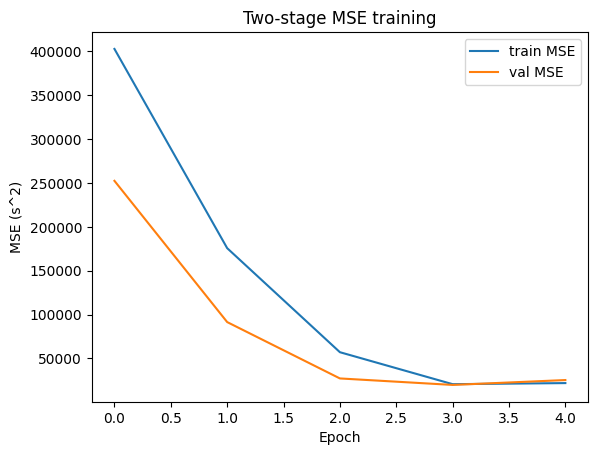

In [9]:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(train_losses, label="train MSE"); plt.plot(test_losses, label="val MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE (s^2)"); plt.legend(); plt.title("Two-stage MSE training"); plt.show()


## 6) ASP Optimizer (MILP)

We implement the single-runway ASP with variables:
- y_i: landing times (continuous)
- w_i: delay indicators (binary; 1 if y_i > T_i)
- d_{i,j}: binary order (1 if i before j)

Objective (simplified as in the paper): minimize sum c_i * w_i where c_i ≈ \hat T_i.

Constraints mirror the paper's (1)–(8) with Big-M.

In [10]:
from mip import Model, xsum, BINARY, CONTINUOUS
def solve_asp_single_instance(pred_T, Ti, Ei, Li, sep_matrix, bigM=10_000.0):
    N = len(pred_T)
    m = Model()
    y = [m.add_var(var_type=CONTINUOUS, name=f"y_{i}") for i in range(N)]
    w = [m.add_var(var_type=BINARY, name=f"w_{i}") for i in range(N)]
    d = [[m.add_var(var_type=BINARY, name=f"d_{i}_{j}") for j in range(N)] for i in range(N)]
    for i in range(N):
        m += y[i] >= float(Ei[i])
        m += y[i] <= float(Li[i])
    for i in range(N):
        m += (y[i] - float(Ti[i])) <= bigM * w[i]
        m += (y[i] - float(Ti[i])) >= -bigM * (1 - w[i])
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            m += d[i][j] + d[j][i] == 1
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            m += y[j] - y[i] >= float(sep_matrix[i][j]) - bigM * d[j][i]
    m.objective = xsum(float(pred_T[i]) * w[i] for i in range(N))
    m.optimize(max_seconds=10)
    order = [[int(d[i][j].x) if i!=j else 0 for j in range(N)] for i in range(N)]
    ysol  = [float(y[i].x) for i in range(N)]
    wsol  = [int(w[i].x) for i in range(N)]
    obj   = float(m.objective_value)
    return {"objective": obj, "y": ysol, "order": order, "w": wsol}


### 6.1 Separation Matrix (toy)
In practice derive s_{i,j} from wake categories. Here we use a constant base with small jitter.

In [11]:
def toy_separation_matrix(N, base=90.0):
    rng = np.random.default_rng(0)
    S = base + rng.integers(-10, 11, size=(N,N)).astype(float)
    np.fill_diagonal(S, 0.0)
    return S


## 7) End-to-end Evaluation (Two-stage)

- Predict \hat T per instance with the trained MLP
- Build time windows [E_i, L_i] around T_i
- Solve MILP and compare costs vs FCFS and True-opt baselines

In [12]:
def evaluate_pipeline(instances_subset, model, features=FEATURES, device=device):
    costs_fcfs, costs_two_stage, costs_true_opt = [], [], []
    for inst in instances_subset:
        N = len(inst)
        X = torch.from_numpy(inst[features].to_numpy(dtype=float)).float().unsqueeze(0).to(device)
        y_true = inst["transit_time_s"].to_numpy(dtype=float)
        with torch.no_grad():
            pred = model(X).cpu().numpy().squeeze(0)
        t0 = inst["entry_time"].min().timestamp()
        entry_rel = inst["entry_time"].apply(lambda t: t.timestamp() - t0).to_numpy(dtype=float)
        Ti = entry_rel + y_true
        Ei = Ti - 60.0
        Li = Ti + 1800.0
        S = toy_separation_matrix(N, base=90.0)
        order_fcfs = np.argsort(entry_rel)
        y_sched = np.zeros(N)
        y_sched[order_fcfs[0]] = Ei[order_fcfs[0]]
        for k in range(1, N):
            i_prev = order_fcfs[k-1]; i_cur = order_fcfs[k]
            y_sched[i_cur] = max(Ei[i_cur], y_sched[i_prev] + S[i_prev][i_cur])
            y_sched[i_cur] = min(y_sched[i_cur], Li[i_cur])
        w_fcfs = (y_sched > Ti).astype(float)
        c_fcfs = (w_fcfs * y_true).sum()
        costs_fcfs.append(c_fcfs)
        res_two = solve_asp_single_instance(pred, Ti, Ei, Li, S)
        costs_two_stage.append(res_two["objective"])
        res_true = solve_asp_single_instance(y_true, Ti, Ei, Li, S)
        costs_true_opt.append(res_true["objective"])
    return np.array(costs_fcfs), np.array(costs_two_stage), np.array(costs_true_opt)

costs_fcfs, costs_two_stage, costs_true = evaluate_pipeline([instances[i] for i in test_idx], model)
print("Mean FCFS cost:      ", costs_fcfs.mean())
print("Mean Two-stage cost: ", costs_two_stage.mean())
print("Mean True-opt cost:  ", costs_true.mean())


Mean FCFS cost:       3761.8246687593046
Mean Two-stage cost:  1808.3707168013962
Mean True-opt cost:   1735.8759398614604


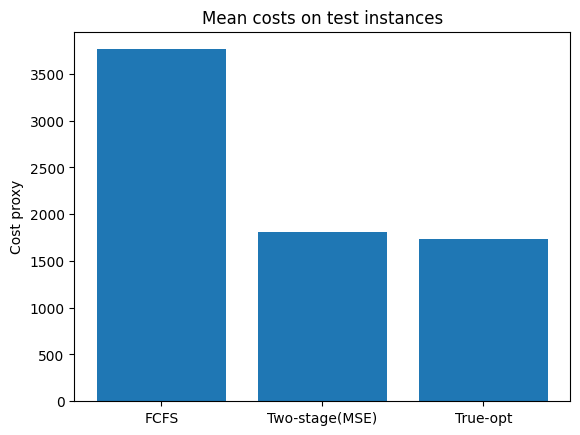

In [13]:
import matplotlib.pyplot as plt
labels = ["FCFS","Two-stage(MSE)","True-opt"]
means = [costs_fcfs.mean(), costs_two_stage.mean(), costs_true.mean()]
plt.figure(); plt.bar(labels, means)
plt.title("Mean costs on test instances"); plt.ylabel("Cost proxy"); plt.show()


## 8) (Optional) SPO⁺ End-to-End Training with PyEPO

The paper trains with **SPO⁺** so the predictor learns from **decision loss**. PyEPO provides convenient layers.
**Note:** For complex MILPs like ASP, you need to express the problem in PyEPO's standard form.
Below is a **template** showing how to connect predicted costs to an optimization layer. You should adapt the constraint matrices to match the ASP formulation.

In [ ]:
# TEMPLATE ONLY — requires encoding the ASP in PyEPO's standard form.
# from pyepo.func import SPOPlus
# from pyepo import EPO
# spo_plus = SPOPlus()
# class ASPProblem(torch.nn.Module):
#     def __init__(self, ...):
#         super().__init__()
#         # Build standard-form matrices for EPO
#     def forward(self, cost_vec):
#         # Solve ASP with given costs
#         return ...
# # Training loop sketch for SPO+ would go here.


## 9) (Optional) Fairness & Stability

Compute order mismatches and simple delay statistics compared to true-opt.

In [14]:
def order_from_matrix(order_mat):
    N = len(order_mat)
    wins = [(i, sum(order_mat[i][j] for j in range(N))) for i in range(N)]
    return [i for i,_ in sorted(wins, key=lambda t: -t[1])]

def compare_orders(res1, res2):
    o1 = order_from_matrix(res1["order"])
    o2 = order_from_matrix(res2["order"])
    N = len(o1)
    pos2 = {o2[k]: k for k in range(N)}
    mismatches = 0
    for i in range(N):
        for j in range(i+1, N):
            a, b = o1[i], o1[j]
            if (pos2[a] - pos2[b]) < 0:
                mismatches += 1
    return mismatches

# Demo on one instance
sample_inst = instances[test_idx[0]]
X = torch.from_numpy(sample_inst[FEATURES].to_numpy(dtype=float)).float().unsqueeze(0).to(device)
with torch.no_grad():
    pred = model(X).cpu().numpy().squeeze(0)
t0 = sample_inst["entry_time"].min().timestamp()
entry_rel = sample_inst["entry_time"].apply(lambda t: t.timestamp() - t0).to_numpy(dtype=float)
Ti = entry_rel + sample_inst["transit_time_s"].to_numpy(dtype=float)
Ei = Ti - 60.0; Li = Ti + 1800.0; S = toy_separation_matrix(len(sample_inst), base=90.0)
res_pred = solve_asp_single_instance(pred, Ti, Ei, Li, S)
res_true = solve_asp_single_instance(sample_inst["transit_time_s"].to_numpy(dtype=float), Ti, Ei, Li, S)
print("Order mismatches (pred vs true):", compare_orders(res_pred, res_true))


Order mismatches (pred vs true): 88


---

## 10) Next Steps
- Replace synthetic data with your **OpenSky arrivals** and **METAR/ATMAP** features.
- Encode the ASP in **PyEPO** form if you want **SPO⁺** training; otherwise, two-stage + optimization is already functional.
- Tune normalization, model size, and separation rules by wake categories.

**Targets to mirror the paper:** learning curves, regret distributions, mean cost comparisons, fairness metrics.